# Age Cross-Prediction

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data

X, Y, demographics, population = get_data(wisc_level=5)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 6 | Age: (380,) | Population: adhd


In [3]:
from common.scoring import (unimetric_scorer, 
                            custom_permutation_test_score, 
                            N_PERM, SCORING, RKF_10_10)
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Run for one target, one age bin

In [4]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'{selected_target}: {y.shape}')

WISC_FSIQ: (380,)


In [5]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
bin_1_X, bin_1_y = bin_1[0], bin_1[1]
bin_2_X, bin_2_y = bin_2[0], bin_2[1]
bin_3_X, bin_3_y = bin_3[0], bin_3[1]

print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

bin_1_cv = [(train, test) for train, test in RKF_10_10.split(bin_1_X)]
bin_2_cv = [(train, test) for train, test in RKF_10_10.split(bin_2_X)]
bin_3_cv = [(train, test) for train, test in RKF_10_10.split(bin_3_X)]

Bin 1: (114, 34716) | Bin 2: (152, 34716) | Bin 3: (114, 34716)


In [6]:
# From previous results
bin_alphas = [5000, 5000, 5000]

### Run cross-validation (train all, test bin)

### Run cross-validation (train bin, test bin)

### Run permutation-test (train bin, test bin)

In [28]:
%%time
bin_scores = [[], [], []]
bin_labels = ['Bin 1', 'Bin 2', 'Bin 3']

pipe = make_pipeline(StandardScaler(), Ridge(alpha=bin_alphas[0]))

n_perm = 10
results = custom_permutation_test_score(
#     pipe, bin_2, bin_1, bin_3, bin_2_cv, bin_1_cv, bin_3_cv, n_perm, unimetric_scorer)
    pipe, bin_1, bin_2, bin_3, bin_1_cv, bin_2_cv, bin_3_cv, n_perm, unimetric_scorer)

print(f'n={n_perm},', selected_target)
print('r-values: {:.4f}, {:.4f}, {:.4f}'.format(*results[0]))
print('p-values: {:.4f}, {:.4f}, {:.4f}'.format(*results[2]))
print('mean permutation r-values: {:.4f}, {:.4f}, {:.4f}'.format(*[np.mean(perms) for perms in results[1]]))
# print(results)

n=10, WISC_FSIQ
r-values: 0.2544, 0.3321, 0.1846
p-values: 0.1818, 0.0909, 0.0909
(array([0.25440476, 0.33212304, 0.18462953]), array([[-0.05240988, -0.14689692, -0.13838407,  0.08382782,  0.08023471,
         0.31897803,  0.05077738, -0.18130092,  0.24230137,  0.00652196],
       [ 0.04080545, -0.13595897,  0.04110484, -0.12680654, -0.02583986,
         0.03484421,  0.10202111,  0.01902736,  0.04205218, -0.0839409 ],
       [ 0.01775909, -0.15439094, -0.05904813,  0.14444708, -0.04725846,
        -0.01007384, -0.09457919,  0.00966965, -0.10079958, -0.0954622 ]]), [0.18181818181818182, 0.09090909090909091, 0.09090909090909091])
CPU times: user 10min 27s, sys: 13.1 s, total: 10min 40s
Wall time: 1min 4s


In [32]:
results[1]

array([[-0.05240988, -0.14689692, -0.13838407,  0.08382782,  0.08023471,
         0.31897803,  0.05077738, -0.18130092,  0.24230137,  0.00652196],
       [ 0.04080545, -0.13595897,  0.04110484, -0.12680654, -0.02583986,
         0.03484421,  0.10202111,  0.01902736,  0.04205218, -0.0839409 ],
       [ 0.01775909, -0.15439094, -0.05904813,  0.14444708, -0.04725846,
        -0.01007384, -0.09457919,  0.00966965, -0.10079958, -0.0954622 ]])

<AxesSubplot:xlabel='Bin', ylabel='r'>

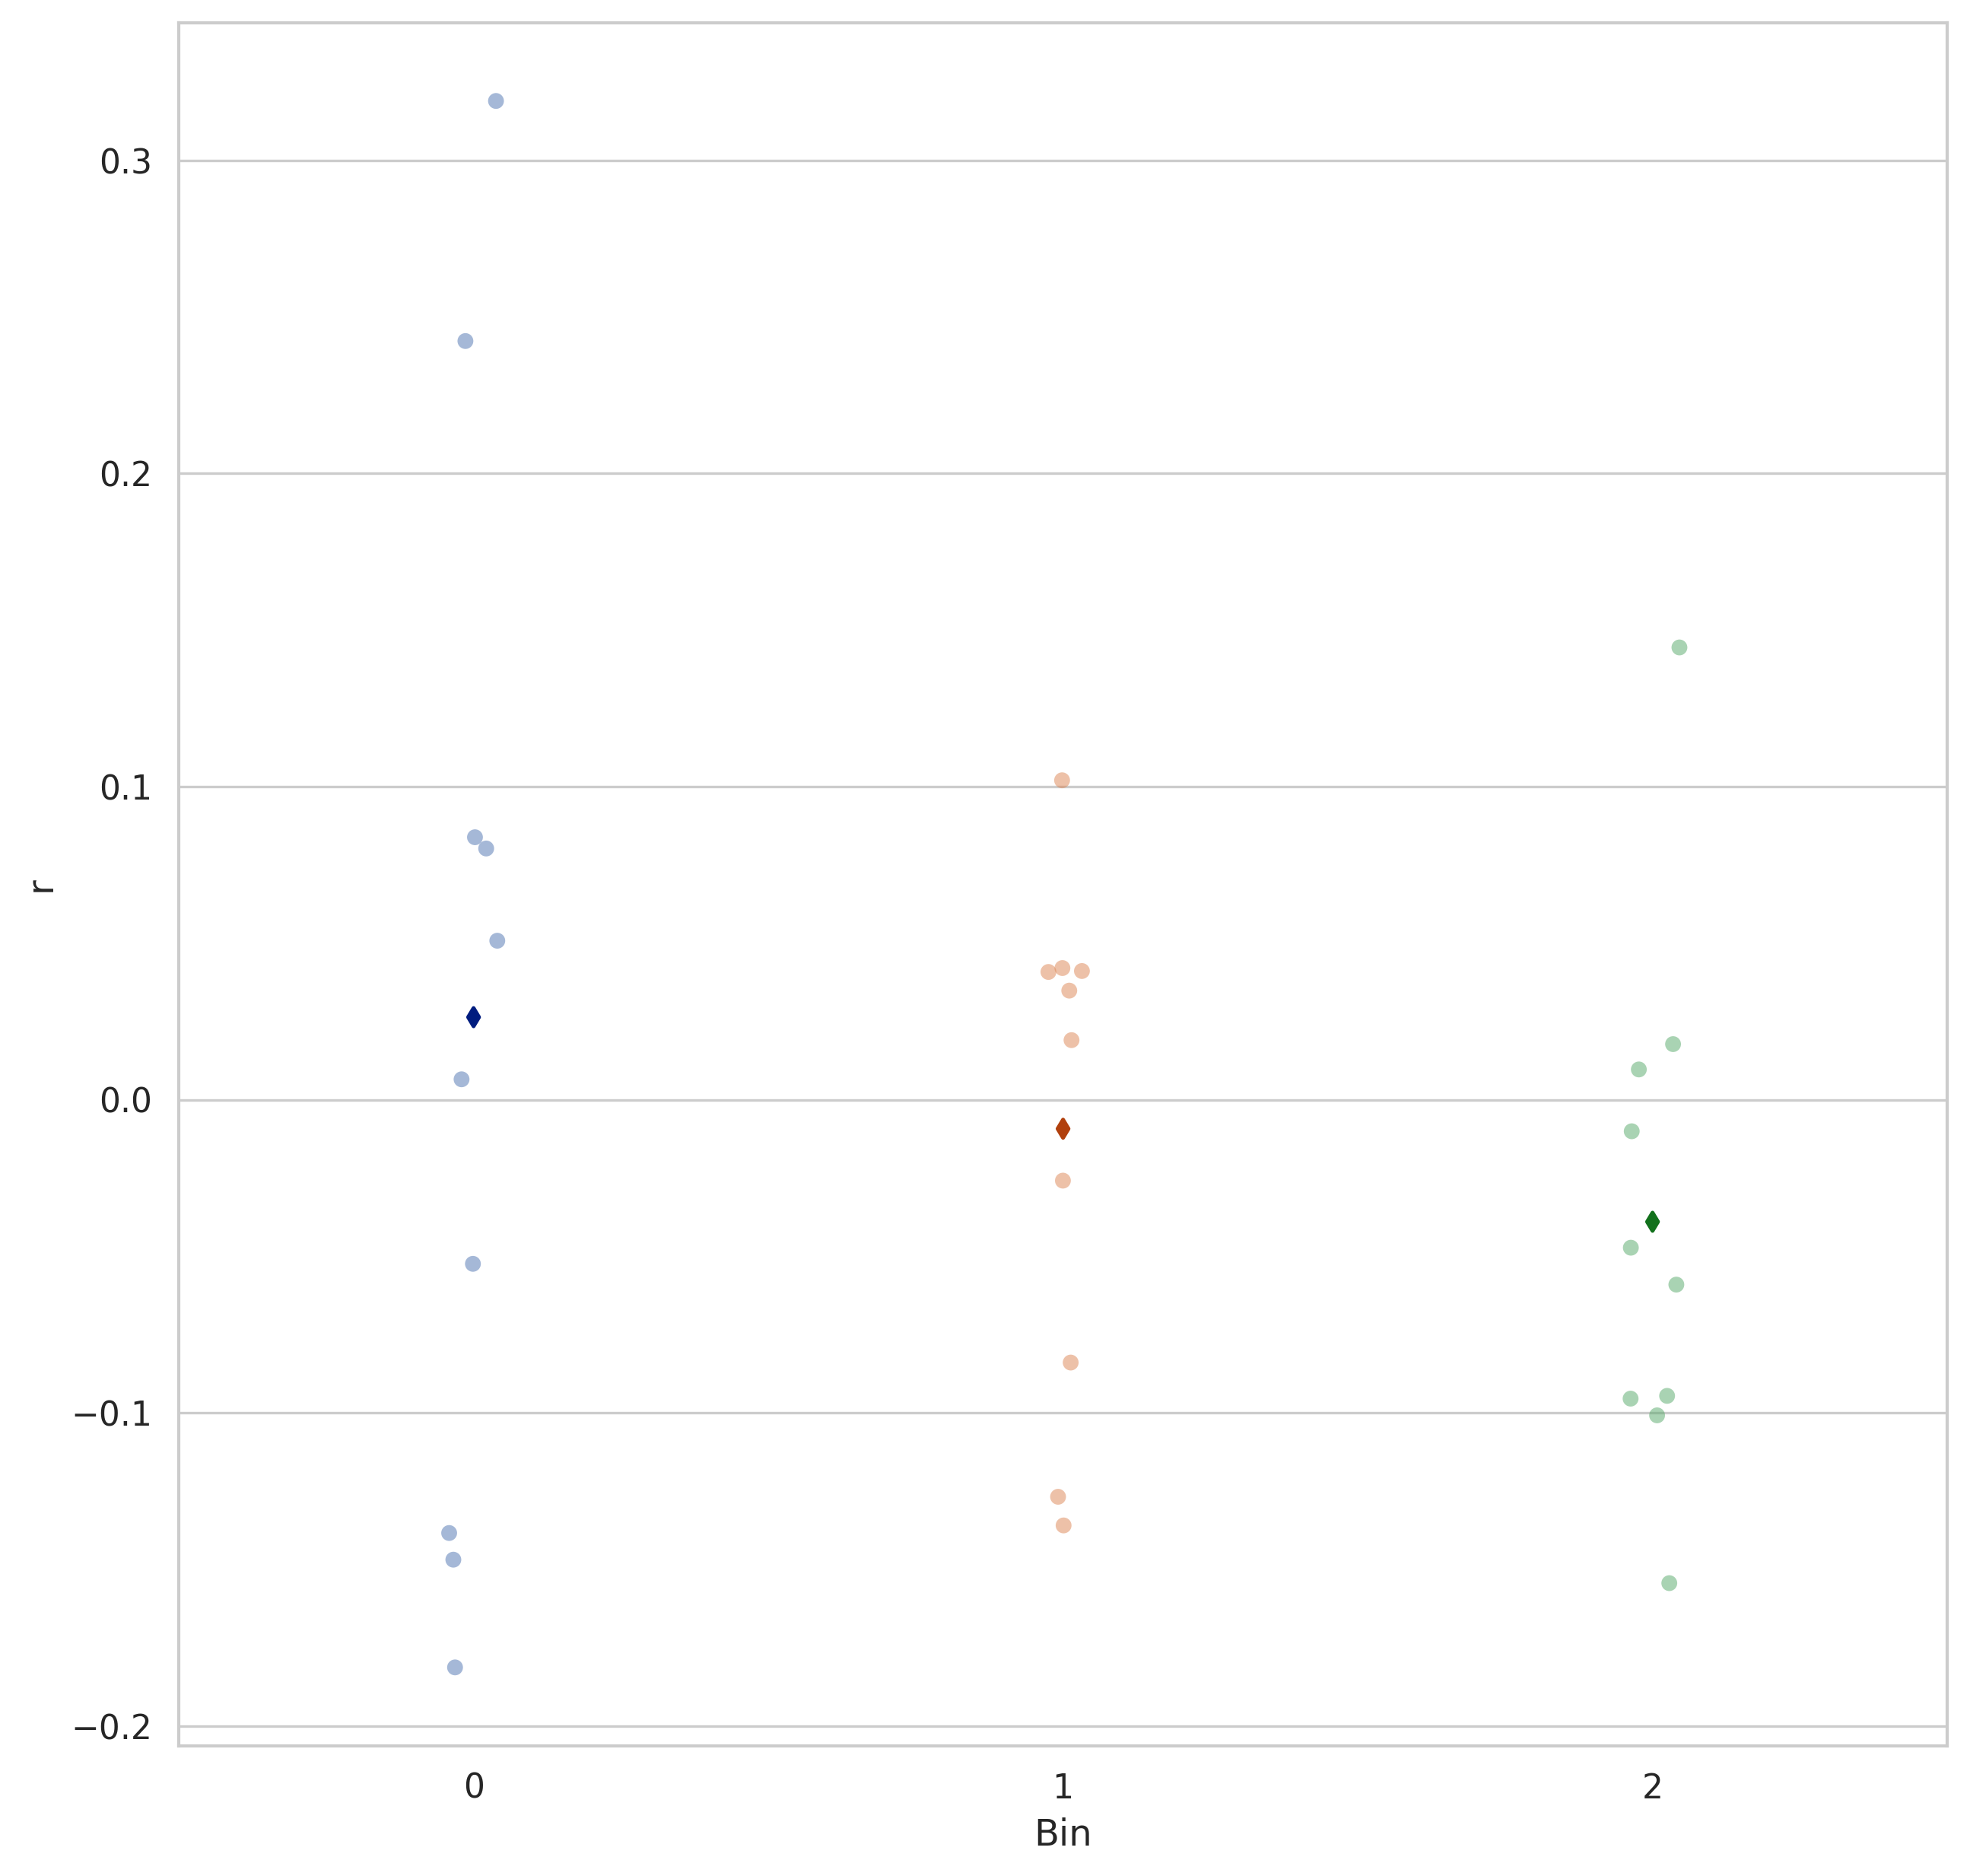

In [48]:
data = pd.melt(pd.DataFrame(results[1]).T, var_name='Bin', value_name='r')
# data['r'] = data['r'].astype('float64')
# display(data)
# 
# Initialize the figure
f, ax = plt.subplots()
# sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x='Bin', y='r', data=data, alpha=.5, jitter=0.05, zorder=1)

# # Show the conditional means, aligning each pointplot in the
# # center of the strips by adjusting the width allotted to each
# # category (.8 by default) by the number of hue levels
sns.pointplot(x='Bin', y='r',data=data, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)

In [19]:
bin_1_coefs = coefs.copy()

In [26]:
bin_2_coefs = coefs.copy()

In [24]:
bin_3_coefs = coefs.copy()

### ICC

In [29]:
%%time
import pingouin as pg

group_one = pd.DataFrame(np.squeeze(np.array(bin_2_coefs), axis=2))
group_one['group'] = 'g1'

group_two = pd.DataFrame(np.squeeze(np.array(bin_3_coefs), axis=2))
group_two['group'] = 'g2'

group_one_two = pd.concat([group_one, group_two])
icc_data = pd.melt(group_one_two, id_vars='group', var_name='connection', 
                   value_name='weight', ignore_index=False)
# display(icc_data)

icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='group', ratings='weight').round(3)
icc.set_index("Type")

CPU times: user 2min 2s, sys: 1.52 s, total: 2min 3s
Wall time: 2min 13s


,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.111,1.249,34715,34716,0.0,"[0.1, 0.12]"
ICC2,Single random raters,0.111,1.249,34715,34715,0.0,"[0.1, 0.12]"
ICC3,Single fixed raters,0.111,1.249,34715,34715,0.0,"[0.1, 0.12]"
ICC1k,Average raters absolute,0.200,1.249,34715,34716,0.0,"[0.18, 0.22]"
ICC2k,Average random raters,0.199,1.249,34715,34715,0.0,"[0.18, 0.22]"
ICC3k,Average fixed raters,0.199,1.249,34715,34715,0.0,"[0.18, 0.22]"
